In [1]:
# --- Request jobs for increasing dataset sizes ---

import os
import requests
import numpy as np
import tensorflow as tf
import yaml
import shutil
from PIL import Image

API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
DOWNLOADS = os.path.join(os.path.expanduser("~"), "Downloads")

def create_model():
    # Use a fixed model for all dataset sizes
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def save_images_per_class(x, y, base_folder):
    os.makedirs(base_folder, exist_ok=True)
    class_counts = {i: 0 for i in range(10)}
    for class_idx in range(10):
        os.makedirs(os.path.join(base_folder, f"class_{class_idx}"), exist_ok=True)
    for i in range(len(x)):
        label = int(y[i])
        img_uint8 = (x[i] * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8)
        img_path = os.path.join(base_folder, f"class_{label}", f"image_{class_counts[label]}.png")
        img_pil.save(img_path)
        class_counts[label] += 1

# Choose your dataset sizes
dataset_sizes = [100, 500, 1000]
job_ids = []

for size in dataset_sizes:
    # Generate random dataset
    x = np.random.rand(size, 32, 32, 3).astype(np.float32)
    y = np.random.randint(0, 10, size).astype(np.int64)
    dataset_folder = os.path.join(DOWNLOADS, f"dataset_analysis_{size}")
    save_images_per_class(x, y, dataset_folder)

    # YAML definition
    yaml_path = os.path.join(DOWNLOADS, f"dataset_analysis_{size}_definition.yaml")
    dataset_definition = {
        "type": "image",
        "image_size": [32, 32],
        "input_shape": [32, 32, 3],
        "output_shape": [10],
        "preprocessing": {"normalize": True}
    }
    with open(yaml_path, "w") as f:
        yaml.dump(dataset_definition, f)

    # Save fixed model (only once)
    model_path = os.path.join(DOWNLOADS, "dataset_analysis_model.keras")
    if not os.path.exists(model_path):
        model = create_model()
        model.save(model_path)

    # Zip dataset
    shutil.make_archive(dataset_folder, 'zip', dataset_folder)
    dataset_zip = dataset_folder + ".zip"

    files = {
        "model": open(model_path, "rb"),
        "dataset": open(dataset_zip, "rb"),
        "dataset_definition": open(yaml_path, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"dataset_analysis_model",
        "epochs": 1,
    }
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted dataset size {size}: {response.status_code} {response.text}")
    job_id = response.json().get("job_id")
    job_ids.append(job_id)

Submitted dataset size 100: 200 {"job_id":"f3f2c8ff-88c6-4fca-b611-4259d5eced07","status":"Training started","unique_dir":"d1a63588-a0a3-4e7e-8b45-7350325dff60"}
Submitted dataset size 500: 200 {"job_id":"78bf9a35-1db4-46e5-900d-01c4d7141267","status":"Training started","unique_dir":"a8c208b1-d5d6-45b3-8004-570ae86e745d"}
Submitted dataset size 1000: 200 {"job_id":"3101e6a5-dbb2-4550-89f2-5dcc063ec18f","status":"Training started","unique_dir":"0f1b81c2-dffe-4db1-b2f8-dfc42b6f881a"}


Download the job folders from MinIO for analysis !!

   Dataset Size  Dataset Zip Size (KB)  Definition Size (KB)  \
0           100             322.326172               0.12207   
1           500            1608.634766               0.12207   
2          1000            3216.617188               0.12207   

   Input Model Size (KB)  Trained Model Size (KB)  AIBOM Size (KB)  \
0             302.291992                864.27832        13.349609   
1             302.291992                864.27832        13.364258   
2             302.291992                864.27832        13.378906   

   Logs Size (KB)  Metrics Size (KB)  RunLink Size (KB)  \
0        4.251953           0.103516           1.299805   
1        4.251953           0.118164           1.299805   
2        4.251953           0.131836           1.301758   

   Total Job Folder Size (KB)  AIBOM % of Trained Model  
0                 1508.023438                  1.544596  
1                 2794.361328                  1.546291  
2                 4402.374023                  1.54

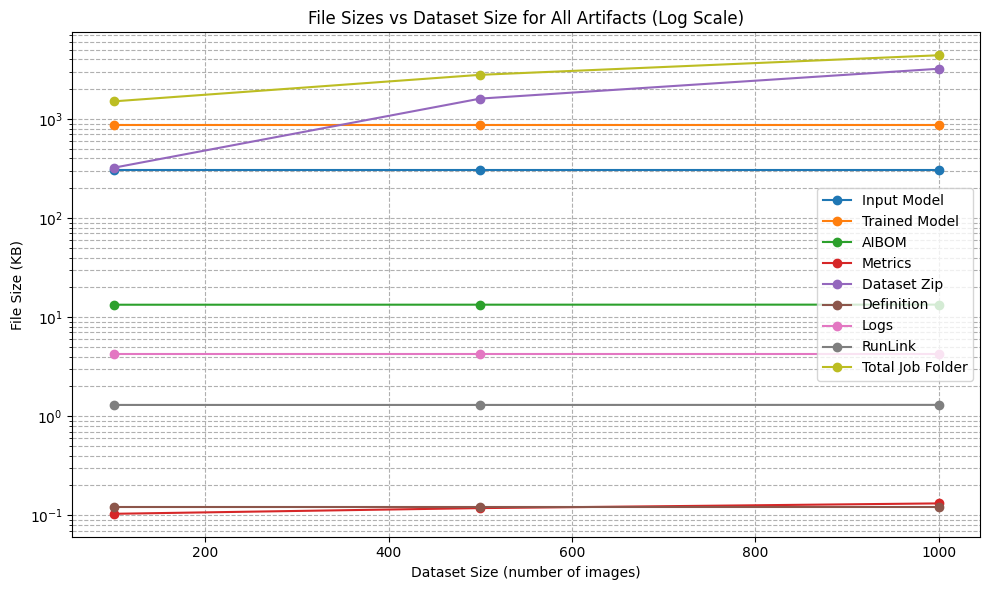

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# List your dataset sizes and corresponding job folders here
dataset_sizes = [100, 500, 1000]  # Example: number of images in each dataset
job_folders = [
    "d1a63588-a0a3-4e7e-8b45-7350325dff60",   # replace with actual folder name for 100 images
    "a8c208b1-d5d6-45b3-8004-570ae86e745d",   # replace with actual folder name for 500 images
    "0f1b81c2-dffe-4db1-b2f8-dfc42b6f881a",  # replace with actual folder name for 1000 images
]

DOWNLOADS = Path.home() / "Downloads"

input_model_sizes = []
trained_model_sizes = []
aibom_sizes = []
dataset_zip_sizes = []
definition_sizes = []
logs_sizes = []
metrics_sizes = []
runlink_sizes = []
total_folder_sizes = []

for size, folder in zip(dataset_sizes, job_folders):
    folder_path = DOWNLOADS / folder
    dataset_file = folder_path / "dataset" / f"dataset_analysis_{size}.zip"
    definition_file = folder_path / "definition" / f"dataset_analysis_{size}_definition.yaml"
    input_model_file = folder_path / "model" / "dataset_analysis_model.keras"  # or whatever fixed model you used
    output_path = folder_path / "output"
    trained_model_file = output_path / "trained_model.keras"
    aibom_file = output_path / "cyclonedx_bom.json"
    logs_file = output_path / "logs.log"
    metrics_file = output_path / "metrics.json"
    runlink_file = next(output_path.glob("run_training.*.link"), None)

    dataset_zip_sizes.append(dataset_file.stat().st_size / 1024 if dataset_file.exists() else None)
    definition_sizes.append(definition_file.stat().st_size / 1024 if definition_file.exists() else None)
    input_model_sizes.append(input_model_file.stat().st_size / 1024 if input_model_file.exists() else None)
    trained_model_sizes.append(trained_model_file.stat().st_size / 1024 if trained_model_file.exists() else None)
    aibom_sizes.append(aibom_file.stat().st_size / 1024 if aibom_file.exists() else None)
    logs_sizes.append(logs_file.stat().st_size / 1024 if logs_file.exists() else None)
    metrics_sizes.append(metrics_file.stat().st_size / 1024 if metrics_file.exists() else None)
    runlink_sizes.append(runlink_file.stat().st_size / 1024 if runlink_file and runlink_file.exists() else None)

    # Calculate total folder size in KB
    total_size = sum(f.stat().st_size for f in folder_path.rglob('*') if f.is_file()) / 1024
    total_folder_sizes.append(total_size)

df = pd.DataFrame({
    "Dataset Size": dataset_sizes,
    "Dataset Zip Size (KB)": dataset_zip_sizes,
    "Definition Size (KB)": definition_sizes,
    "Input Model Size (KB)": input_model_sizes,
    "Trained Model Size (KB)": trained_model_sizes,
    "AIBOM Size (KB)": aibom_sizes,
    "Logs Size (KB)": logs_sizes,
    "Metrics Size (KB)": metrics_sizes,
    "RunLink Size (KB)": runlink_sizes,
    "Total Job Folder Size (KB)": total_folder_sizes,
    "AIBOM % of Trained Model": [100 * a / m if m else None for a, m in zip(aibom_sizes, trained_model_sizes)]
})
print(df)

plt.figure(figsize=(10,6))
plt.plot(df["Dataset Size"], df["Input Model Size (KB)"], marker='o', label="Input Model")
plt.plot(df["Dataset Size"], df["Trained Model Size (KB)"], marker='o', label="Trained Model")
plt.plot(df["Dataset Size"], df["AIBOM Size (KB)"], marker='o', label="AIBOM")
plt.plot(df["Dataset Size"], df["Metrics Size (KB)"], marker='o', label="Metrics")
plt.plot(df["Dataset Size"], df["Dataset Zip Size (KB)"], marker='o', label="Dataset Zip")
plt.plot(df["Dataset Size"], df["Definition Size (KB)"], marker='o', label="Definition")
plt.plot(df["Dataset Size"], df["Logs Size (KB)"], marker='o', label="Logs")
plt.plot(df["Dataset Size"], df["RunLink Size (KB)"], marker='o', label="RunLink")
plt.plot(df["Dataset Size"], df["Total Job Folder Size (KB)"], marker='o', label="Total Job Folder")

plt.xlabel("Dataset Size (number of images)")
plt.ylabel("File Size (KB)")
plt.title("File Sizes vs Dataset Size for All Artifacts (Log Scale)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

The AIBOM size increases slightly with dataset size because it embeds dataset-specific metadata (hashes, file names, paths, and possibly more metrics or properties), and these fields can become marginally larger as the dataset grows. However, the increase is small because the AIBOM does not include the dataset itself, only its metadata and references.